In [2]:
import json
import gzip

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

import scipy.sparse as sp

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [3]:
def load(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return json.load(f)


def extract(data):
    content = ["\n".join([a["title"]] + a["paragraphs"]) for a in data]
    topics = [[a.get("topics", "unknown")] for a in data]
    return content, topics

In [4]:
train = load("../data/rtvslo_train.json")
test = load("../data/rtvslo_test.json")

In [5]:
print(train[0])

{'authors': ['Aljoša Masten'], 'date': '2017-08-05T16:07:03', 'lead': 'New Horizons', 'n_comments': 29, 'paragraphs': ['Nasina sondaje svojo zgodovinsko vlogo že opravila. Kot je znano, je leta 2015 nazaj fotografije Plutona, s čimer je človeštvo izpolnilo celoten Osončja ; podvig, ki je trajal kar (ali najmanj, kot se vzame) 60 let. Vse, kar pride zatem, je dodana vrednost. Sonda se zdaj iz ogledovalke enega planeta spreminja v pionirja, ki v področja, kjer nikoli poprej nobeno živo bitje (zelo verjetno) ni poseglo na tak ali drugačen način. S hitrostjo 51.000 kilometrov na uro relativno na Sonce beži stran, se razgleduje po temačnem Kuiperjevem pasu, polnem ledenega drobirja in pritlikavih planetov, in nazaj na Zemljo pošilja meritve. Povratni signal do nas zdaj potuje 10 ur, kažejo Nasini, saj mora premeriti kar 5,7 milijarde kilometrov. Misija New Horizons tako zdaj dobiva značilnosti slavnih Voyagerjev, ki, mimogrede, jeseni 40 let delovanja. A v nasprotju s Popotniki, pred kateri

In [6]:
import pandas as pd

df = pd.DataFrame(train)

In [7]:
mean_comments = df['n_comments'].mean()
var_comments = df['n_comments'].var()

print(f"Mean: {mean_comments}, Variance: {var_comments}")


Mean: 39.7549220585095, Variance: 6914.653275544332


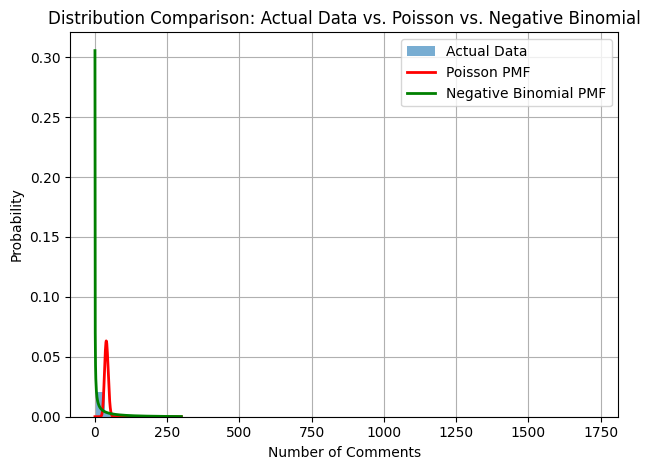

In [101]:
import json

# Extract n_comments from your dataset
n_comments_list = [article["n_comments"] for article in train]

# Convert to pandas Series for convenience
n_comments = pd.Series(n_comments_list)

# Compute mean and variance
mean_comments = n_comments.mean()
var_comments = n_comments.var()

# Estimate Negative Binomial parameters using method of moments
p = mean_comments / var_comments
n = mean_comments * p / (1 - p)

# Range for plotting
x = np.arange(0, min(300, int(n_comments.max()) + 1))

# Plot histogram of your actual data
plt.hist(n_comments, bins=50, alpha=0.6, density=True, label='Actual Data')

# Plot Poisson PMF
plt.plot(x, stats.poisson.pmf(x, mean_comments), 'r-', lw=2, label='Poisson PMF')

# Plot Negative Binomial PMF
plt.plot(x, stats.nbinom.pmf(x, n, p), 'g-', lw=2, label='Negative Binomial PMF')

plt.xlabel('Number of Comments')
plt.ylabel('Probability')
plt.legend()
plt.title('Distribution Comparison: Actual Data vs. Poisson vs. Negative Binomial')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# import torch
# import pandas as pd
# from tqdm import tqdm
# from sentence_transformers import SentenceTransformer

# # Load multilingual SBERT model (MPNet backbone, supports Slovene)
# model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
# model.eval()

# # Load your dataset
# df = pd.read_json("rtvslo_train.json")  # assumes a list of article dicts

# df['full_text'] = df['title'] + " " + df['lead'] + " " + df['paragraphs'].apply(lambda x: " ".join(x))

# # Encode all articles
# embeddings = []
# for text in tqdm(df['full_text']):
#     emb = model.encode(text, convert_to_tensor=True)  # returns a torch.Tensor
#     embeddings.append(emb)

# # Stack into one tensor
# embeddings_tensor = torch.stack(embeddings)
# torch.save(embeddings_tensor, "text_embeddings.pt")

# # Also save the targets
# targets = torch.tensor(df['n_comments'].values, dtype=torch.float32)
# torch.save(targets, "targets.pt")


In [54]:
import pandas as pd
import numpy as np
import torch
from datetime import datetime

# Load article data
df = pd.read_json("../data/rtvslo_train.json")

# Parse dates
df['date'] = pd.to_datetime(df['date'])

# Reference date: latest in dataset
ref_date = df['date'].max()
print(ref_date)

# Feature 1: Days since latest
df['days_since'] = (ref_date - df['date']).dt.days
df['days_since'] = df['days_since'] / df['days_since'].max()
print(df['days_since'])

# Feature 3: Weekday (cyclical)
df['weekday'] = df['date'].dt.weekday
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

# Select time features
#time_features = df[['days_since', 'weekday_sin', 'weekday_cos']].values
time_features = df[['days_since']].values
time_features = torch.tensor(time_features, dtype=torch.float32)

# Save for training
torch.save(time_features, "time_features.pt")


2025-03-06 23:03:21
0        1.000000
1        0.998195
2        0.997834
3        0.997112
4        0.996751
           ...   
46825    0.000000
46826    0.000000
46827    0.000000
46828    0.000000
46829    0.000000
Name: days_since, Length: 46830, dtype: float64


### Binomial

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# --- Loss ---
class NegativeBinomialLoss(nn.Module):
    def forward(self, y_true, mu, alpha):
        eps = 1e-8
        mu = torch.clamp(mu, min=eps, max=1e6)           # Stability
        alpha = torch.clamp(alpha, min=eps, max=10.0)     # Stability

        r = 1.0 / (alpha + eps)
        p = r / (r + mu + eps)

        log_prob = (
            torch.lgamma(y_true + r)
            - torch.lgamma(r)
            - torch.lgamma(y_true + 1)
            + r * torch.log(p + eps)
            + y_true * torch.log(1 - p + eps)
        )
        return -torch.mean(log_prob)

# --- Model ---
class CommentPredictor(nn.Module):
    def __init__(self, input_dim_text, input_dim_time, hidden_dim=128, dropout_prob=0.5):
        super().__init__()
        self.text_fc = nn.Linear(input_dim_text, hidden_dim)
        self.time_fc = nn.Linear(input_dim_time, hidden_dim)
        self.combined_fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.mu_head = nn.Linear(hidden_dim, 1)
        self.alpha_head = nn.Linear(hidden_dim, 1)

    def forward(self, text_embed, time_feat):
        x_text = F.relu(self.text_fc(text_embed))
        x_time = F.relu(self.time_fc(time_feat))
        x = torch.cat([x_text, x_time], dim=1)
        x = F.relu(self.combined_fc(x))
        x = self.dropout(x)
        mu = torch.exp(self.mu_head(x))          # Ensure positivity
        alpha = F.softplus(self.alpha_head(x))    # Ensure positivity
        return mu.squeeze(1), alpha.squeeze(1)

# --- Load data ---
text_embeddings = torch.load("sloberta_embeddings.pt", weights_only=True, map_location='cpu')
time_features = torch.load("time_features.pt", weights_only=True, map_location='cpu')
targets = torch.load("targets.pt", weights_only=True, map_location='cpu')

# ✅ Notice: No log1p on targets — Negative Binomial expects **raw counts**

dataset = TensorDataset(text_embeddings, time_features, targets)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CommentPredictor(
    input_dim_text=text_embeddings.shape[1],
    input_dim_time=time_features.shape[1],
    hidden_dim=128,
    dropout_prob=0.5
).to(device)

criterion = NegativeBinomialLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

print("Text Embeddings:", text_embeddings.shape, "Time Features:", time_features.shape, "Targets:", targets.shape)

# --- Training ---
best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0

for epoch in range(50):
    model.train()
    total_loss = 0
    for text, time, y in train_loader:
        text, time, y = text.to(device), time.to(device), y.to(device)
        optimizer.zero_grad()
        mu, alpha = model(text, time)
        loss = criterion(y, mu, alpha)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for text, time, y in val_loader:
            text, time, y = text.to(device), time.to(device), y.to(device)
            mu, alpha = model(text, time)
            loss = criterion(y, mu, alpha)
            val_loss += loss.item()
            val_preds.append(mu.cpu())
            val_targets.append(y.cpu())

    val_loss /= len(val_loader)
    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    # Metrics on counts
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    mae = mean_absolute_error(val_targets, val_preds)
    rmse = np.sqrt(np.mean((val_targets - val_preds)**2))
    r2 = r2_score(val_targets, val_preds)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model_nb_final.pt")
        print("📦 Saved new best model!")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f}")



Text Embeddings: torch.Size([46830, 768]) Time Features: torch.Size([46830, 1]) Targets: torch.Size([46830])
📦 Saved new best model!
Epoch 1 | Train Loss: 5.4577 | Val Loss: 4.3033 | MAE: 43.46 | RMSE: 83.22 | R²: 0.0706
📦 Saved new best model!
Epoch 2 | Train Loss: 4.3173 | Val Loss: 4.1690 | MAE: 37.15 | RMSE: 77.58 | R²: 0.1923
📦 Saved new best model!
Epoch 3 | Train Loss: 4.2279 | Val Loss: 4.1234 | MAE: 38.01 | RMSE: 75.33 | R²: 0.2384
📦 Saved new best model!
Epoch 4 | Train Loss: 4.1967 | Val Loss: 4.0839 | MAE: 32.69 | RMSE: 74.00 | R²: 0.2650
📦 Saved new best model!
Epoch 5 | Train Loss: 4.1750 | Val Loss: 4.0654 | MAE: 35.37 | RMSE: 72.94 | R²: 0.2858
📦 Saved new best model!
Epoch 6 | Train Loss: 4.1590 | Val Loss: 4.0545 | MAE: 37.69 | RMSE: 74.02 | R²: 0.2645
📦 Saved new best model!
Epoch 7 | Train Loss: 4.1373 | Val Loss: 4.0423 | MAE: 30.79 | RMSE: 72.48 | R²: 0.2950
📦 Saved new best model!
Epoch 8 | Train Loss: 4.1287 | Val Loss: 4.0249 | MAE: 33.96 | RMSE: 71.46 | R²: 0.